# Getting started

👋 Welcome to Deepnote! If you're new to notebooks, we recommend you browse through this guide and watch the videos (it takes about 5 minutes). You can also pick what's most relevant to you right now and come back anytime to see the rest. 

## 1. Run a cell 🏃
Select the code cell below and click _Run_ in the right sidebar. You can also press <kbd>Shift</kbd>+<kbd>Enter</kbd> to run it and move to the next cell.

![Picture title](image-20210902-230946.png)

Ideas: Introducimos la data en un Pandas. Iteramos sobre las columnas y analizamos los valores posibles para cada columna, incluyendo la clase de cada caso. Podemos crear luego un objeto que sea conjunto o algo asi, y ese objeto le damos el metodo "entropia". Aparte, creamos una funcion que reciba uno de estos conjuntos y tome los atributos que analizamos de la tabla. La funcion itera sobre la lista de atributos y nos devuelve el atributo con mayor ganancia
Ahi miramos si tenemos suficiente ganancia, sit enemos, creamos un nodo y separamos cada caso dependiendo del valor del atributo en subconjuntos. Guardamos los subconjuntos en una lista en el nodo y llamamos al algoritmo con los elementos de la lista.

In [1]:
import pandas as pd
import math
import streamlit as st
import graphviz as graphviz

In [16]:
df = pd.read_csv('data_test.csv')
df['ProblemasCardiacos'].value_counts().items()

T    6
F    4
Name: ProblemasCardiacos, dtype: int64

In [20]:
list(df['ProblemasCardiacos'].value_counts().values)

[6, 4]

In [3]:
df['ProblemasCardiacos'].mode().item()

'T'

![Picture title](entropy.png)


![Picture title](entropyAt.png)

In [4]:
classValues = list(df['ProblemasCardiacos'].value_counts().index) # Valores posibles de la columna clase
classValues

['T', 'F']

In [5]:
class SetCases:
    def __init__(self,cases,case_count,class_column_name):
        self.cases = cases
        self.class_column_name = class_column_name
        self.case_count = case_count
        self.columns = list(cases.columns)
        #self.attributes = self.columns
        self.attributes = [item for item in self.columns if item != self.class_column_name] # This is 'A' in the theory
        #self.attributes.remove(self.class_column_name)  
    def cases_count(self):
        self.case_count = self.cases.shape[0]
        return self.case_count
        
    def get_attributes(self) -> list:
        return self.attributes
    
    def entropy(self) -> float:  # Entropy Formula function
        entropy = 0
        counts = self.cases[self.class_column_name].value_counts()
        for item in classValues:
            prob = self.cases[self.cases[self.class_column_name]==item][self.class_column_name].count()/self.case_count
            entropy -= (prob)*(math.log2(prob))
        return round(entropy,3)

    def entropy_attribute(self) -> float: # Entropia de cada tributo de 'A'
        entropy_result = {}
        for attribute in self.attributes:  # Bucle sobre cada atributo de la lista
            result = 0
            attr_indexes = list(self.cases[attribute].value_counts().index)
            attr_counts = list(self.cases[attribute].value_counts().values)
            i=0
            for value in attr_indexes: # Bucle sobre los valores posibles de cada atributo
                attr_entropy = 0
                attr_count = attr_counts[i]

                for c_value in classValues: # Bucle sobre cada caso de un valor posible de un atributo
                    class_count = len(self.cases[(self.cases[attribute]==value)&(self.cases[self.class_column_name]==c_value)])
                    if class_count != 0:
                        attr_entropy -= (class_count/attr_count) * (math.log2((class_count/attr_count)))
                    else:
                        attr_entropy -= 0 #ESTO SE TENDRIA QUE SACAR DE ACA, CUANDO ESTE EL CODIGO COMPLETO ESTO IRIA AL PRINCIPIO
                i+=1

                result += (attr_count/self.case_count) * attr_entropy # Resultado de entropia de un atributo posible
            entropy_result[attribute] = result
        return entropy_result

    def gain(self) -> list: # return [Att, Value]
        entropy = self.entropy()
        entropy_atts = self.entropy_attribute()
        max_gain = 0
        curr_gain = 0
        result = [0,0]
        for key,value in entropy_atts.items():
            curr_gain = float(entropy) - value 
            if curr_gain > max_gain:
                max_gain = curr_gain
                result[0] = key
                result[1] = curr_gain
        return result

    def gain2(self) -> list: # return list of [Att, Value], something like: [[Att1, Value] [Att2, Value]] ESTO ES PARA PROBAR EL GAIN RATIO
        entropy = self.entropy()
        entropy_atts = self.entropy_attribute()
        curr_gain = 0
        max_gain = 0
        result = []
        for key,value in entropy_atts.items():
            curr_gain = float(entropy) - value
            if curr_gain > max_gain:
                result.insert(0, [key, curr_gain])
                max_gain=curr_gain
            else:
                result.append([key, curr_gain])      
        return result
    
    def gain_ratio(self) -> list:
        entropy = self.entropy()
        gain = self.gain2()
        split_info = 0
        max_gain_rate = 0
        result=[0,0]
        for att_name, gain_per_att in gain: # gain_per_att is [Att, Value]
            # We generate a list of all the quantities of occurences of each attribute
            attr_counts = list(self.cases[att_name].value_counts().values)
            split_info = 0
            for attr_count in attr_counts:
                split_info -= (attr_count/self.case_count) * (math.log2((attr_count/self.case_count)))
            curr_gain_rate = gain_per_att / split_info
            if curr_gain_rate > max_gain_rate: 
                max_gain_rate = curr_gain_rate
                result[0] = att_name
                result[1] = curr_gain_rate
        return result

    def is_pure(self) -> bool:
        classes = self.cases[self.class_column_name].unique()
        if len(classes) == 1:
            return True
        return False
    
    def most_frequent_class(self) -> str:
        return self.cases[self.class_column_name].mode().item()
    
    def separate_data(self, attr) -> list: # Esto retorna un arreglo con dataframes
        attr_values = list(self.cases[attr].unique())
        frames = []
        for val in attr_values:
            frames.append(self.cases[self.cases[attr]==val])
        return frames

In [6]:
name_counter = 1

In [21]:
class Node:
    def __init__(self, data: SetCases, id_node: int):
        self.data = data
        self.children = []
        self.curr_class = ''
        self.chosen_att = ''
        self.id_node = id_node
        self.gain = 0
        global name_counter

    def addChildren(self, node):
        self.children.append(node)
        
    def printTree(self, depth: int, graph, previous_node, name_previous_node: int):
        print('###############################################')
        print(f"Depth {depth}")
        print(self.curr_class)
        global name_counter
        if self.chosen_att != '':
            print(f'Created node with name {self.id_node} and label {self.chosen_att}')
            graph.node(name = str(self.id_node),label = f'{self.chosen_att} \n Gain: {self.gain}')
        else:
            print(f'Created node with name {self.id_node} and label {self.curr_class}')
            print(self.data.cases[self.data.class_column_name].value_counts())
            graph.node(name = str(self.id_node), label= f'{self.curr_class} \n Gain: {self.gain} \n {self.data.cases[self.data.class_column_name].value_counts().values}',color='green')
        if depth != 0:
            print(f'Created edge between {name_previous_node} and {self.id_node}')
            graph.edge(str(name_previous_node), str(self.id_node))
        #name_counter+=1
        name_previous_node+=1
        for item in self.children:
            item.printTree(depth+1, graph, self, self.id_node)
        

In [35]:
print(root_node.data.class_column_name)
print(root_node.data.cases)
print(root_node.data.cases[root_node.data.class_column_name])
print(root_node.children[0].data.cases)
print(root_node.children[0].data.cases[root_node.children[0].data.class_column_name])

ProblemasCardiacos
  Hipertenso Colesterol Trigliceridos         Edad Diabeico ProblemasCardiacos
0          F       bajo        normal     menos_40        T                  F
1          T       bajo       elevado     menos_40        T                  F
2          T       bajo       elevado     mayor_60        T                  T
3          T      medio       elevado     mayor_60        F                  T
4          F      medio       elevado     menos_40        F                  T
5          F      medio        normal  entre_40_60        T                  F
6          T       alto        normal  entre_40_60        T                  T
7          T       alto        normal  entre_40_60        T                  T
8          T       alto       elevado     mayor_60        F                  T
9          F       alto        normal     menos_40        F                  F
0    F
1    F
2    T
3    T
4    T
5    F
6    T
7    T
8    T
9    F
Name: ProblemasCardiacos, dtype: object
  

In [22]:
def decisionTree(D : SetCases, A : list, T : Node, guide_int : int):
    global name_counter
    if D.is_pure():
        class_name = D.most_frequent_class()
        T.curr_class = class_name
    elif not A:
        class_name = D.most_frequent_class()
        T.curr_class = class_name
    else:
        print('Depth ' + str(guide_int))
        #gain = D.gain()
        gain = D.gain_ratio()
        #gain = D.gain2()[0]
        print('Attribute chosen '+ gain[0])
        if gain[1] < threshold:
            class_name = D.most_frequent_class()
            T.curr_class = class_name
        else:
            T.chosen_att = gain[0]
            A1 = [item for item in A if item != gain[0]]
            subsets = D.separate_data(gain[0])
            for subset in subsets:
                elem = SetCases(subset, len(subset), D.class_column_name)
                print(f'Name_counter {name_counter} Size {subset.shape}')
                T.gain = round(gain[1],2)
                new_node = Node(elem, name_counter)
                name_counter+=1
                T.addChildren(new_node)
                decisionTree(elem, A1, new_node, guide_int+1)

In [23]:
graph = graphviz.Digraph()

In [24]:
threshold = 0.1
set_init = SetCases(df,len(df),'ProblemasCardiacos')
root_node = Node(set_init, 0)
decisionTree(set_init, set_init.get_attributes(),root_node,0)


Depth 0
Attribute chosen Hipertenso
Name_counter 8 Size (4, 6)
Depth 1
Attribute chosen Trigliceridos
Name_counter 9 Size (3, 6)
Name_counter 10 Size (1, 6)
Name_counter 11 Size (6, 6)
Depth 1
Attribute chosen Edad
Name_counter 12 Size (1, 6)
Name_counter 13 Size (3, 6)
Name_counter 14 Size (2, 6)
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in double_scalars


In [25]:
root_node.printTree(0, graph, root_node,name_counter)

###############################################
Depth 0

Created node with name 0 and label Hipertenso
###############################################
Depth 1

Created node with name 8 and label Trigliceridos
Created edge between 0 and 8
###############################################
Depth 2
F
Created node with name 9 and label F
Created edge between 8 and 9
###############################################
Depth 2
T
Created node with name 10 and label T
Created edge between 8 and 10
###############################################
Depth 1

Created node with name 11 and label Edad
Created edge between 0 and 11
###############################################
Depth 2
F
Created node with name 12 and label F
Created edge between 11 and 12
###############################################
Depth 2
T
Created node with name 13 and label T
Created edge between 11 and 13
###############################################
Depth 2
T
Created node with name 14 and label T
Created edge between 11 and 14


In [26]:
print(root_node.id_node)
print(root_node.children[0].id_node)
print(root_node.children[0].children[0].id_node)

0
8
9


In [27]:
print(len(root_node.children))
print(len(root_node.children[0].children))
print(len(root_node.children[1].children))
print(len(root_node.children[2].children))

2
2
3


IndexError: list index out of range

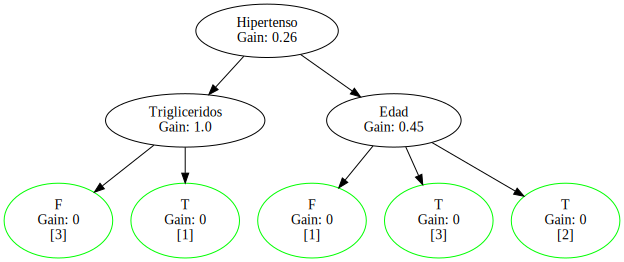

In [28]:

graph 

# Sandbox de pruebas

In [ ]:
setCases = SetCases(df,10,'ProblemasCardiacos')
#setCases.gain()
setCases.separate_data('Hipertenso')[1].head()
#setCases.entropy_attribute()
#print(setCases.most_frequent_class())

,index,Hipertenso,Colesterol,Trigliceridos,Edad,Diabeico,ProblemasCardiacos
0,1,T,bajo,elevado,menos_40,T,F
1,2,T,bajo,elevado,mayor_60,T,T
2,3,T,medio,elevado,mayor_60,F,T
3,6,T,alto,normal,entre_40_60,T,T
4,7,T,alto,normal,entre_40_60,T,T


In [ ]:
a = pd.DataFrame({'a':[1,2,3]})
b = pd.DataFrame({'b':[2,3,4]})

In [ ]:
list(df['ProblemasCardiacos'].unique())

['F', 'T']

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9a66d969-af84-4258-a4a2-724e61aa71b5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>